In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

import re
import sys
import tarfile
from six.moves import urllib
from collections import defaultdict
from skimage.transform import resize
from random import sample

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
base_url = 'https://gitlab.com/yuxuan.chen/storage/'\
    '-/tree/master/MLDS-2019/test_image_'
url = [base_url + str(i) + '.png' for i in range(1, 5)]
!wget $url[0] -O test_image_1.png
!wget $url[1] -O test_image_2.png
!wget $url[2] -O test_image_3.png
!wget $url[3] -O test_image_4.png

# download name dictionary
dict_url = 'https://raw.githubusercontent.com/ageron/handson-ml/'\
    'master/datasets/inception/imagenet_class_names.txt'
!wget $dict_url -O imagenet_class_names.txt

--2019-12-21 17:38:15--  https://git.imp.fu-berlin.de/yuxuac94/storage/raw/master/MLDS-2019/week9/test_image_1.png
Resolving git.imp.fu-berlin.de (git.imp.fu-berlin.de)... 160.45.117.96
Connecting to git.imp.fu-berlin.de (git.imp.fu-berlin.de)|160.45.117.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167848 (164K) [image/png]
Saving to: ‘test_image_1.png’

test_image_1.png    100%[===================>] 163.91K  --.-KB/s    in 0.05s   

2019-12-21 17:38:15 (3.30 MB/s) - ‘test_image_1.png’ saved [167848/167848]

--2019-12-21 17:38:17--  https://git.imp.fu-berlin.de/yuxuac94/storage/raw/master/MLDS-2019/week9/test_image_2.png
Resolving git.imp.fu-berlin.de (git.imp.fu-berlin.de)... 160.45.117.96
Connecting to git.imp.fu-berlin.de (git.imp.fu-berlin.de)|160.45.117.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159614 (156K) [image/png]
Saving to: ‘test_image_2.png’

test_image_2.png    100%[===================>] 155.87K  --.-KB/s 

## High Accuracy for MNIST

In [0]:
# hyperparameter for the model
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = 'SAME'

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 1
conv2_pad = 'SAME'
conv2_dropout_rate = 0.25

pool3_fmaps = conv2_fmaps

n_fc1 = 128
fc1_dropout_rate = 0.5

n_outputs = 10

reset_graph()

In [13]:
# build the model
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name='X')
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name='y')

    training = tf.placeholder_with_default(
        input=False, 
        shape=[], 
        name='training')

# two conv layers
conv1 = tf.layers.conv2d(
    inputs=X_reshaped, 
    filters=conv1_fmaps, 
    kernel_size=conv1_ksize, 
    strides=conv1_stride, 
    padding=conv1_pad, 
    activation=tf.nn.relu, 
    name='conv1')

conv2 = tf.layers.conv2d(
    inputs=conv1, 
    filters=conv2_fmaps, 
    kernel_size=conv2_ksize, 
    strides=conv2_stride, 
    padding=conv2_pad, 
    activation=tf.nn.relu, 
    name='conv2')

# pooling layer
with tf.name_scope('pool3'):
    pool3 = tf.nn.max_pool(
        value=conv2, 
        ksize=[1, 2, 2, 1], 
        strides=[1, 2, 2, 1], 
        padding='VALID')

    pool3_flat = tf.reshape(
        tensor=pool3, 
        shape=[-1, pool3_fmaps * 14 * 14])

    # drop-out
    pool3_flat_drop = tf.layers.dropout(
        inputs=pool3_flat, 
        rate=conv2_dropout_rate, 
        training=training)

with tf.name_scope('fc1'):
    fc1 = tf.layers.dense(
        inputs=pool3_flat_drop, 
        units=n_fc1, 
        activation=tf.nn.relu, 
        name='fc1')
    fc1_drop = tf.layers.dropout(
        inputs=fc1, 
        rate=fc1_dropout_rate, 
        training=training)

with tf.name_scope('output'):
    logits = tf.layers.dense(fc1_drop, n_outputs, name='output')
    Y_proba = tf.nn.softmax(logits, name='Y_proba')

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, 
        labels=y)

    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [0]:
# build batch generator
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [0]:
# load data
(X_train, y_train), (X_test, y_test) = \
    tf.keras.datasets.mnist.load_data()

X_train = X_train.astype(np.float32).reshape(-1, 28 * 28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28 * 28) / 255.0

y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [0]:
# restore and get parameters of the model
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {
        gvar.op.name: value for gvar, value in zip(
                gvars, 
                tf.get_default_session().run(gvars))
    }

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())

    assign_ops = {
        gvar_name: tf.get_default_graph().get_operation_by_name(
            gvar_name + '/Assign'
        ) for gvar_name in gvar_names}

    init_values = {gvar_name: assign_op.inputs[1] \
                   for gvar_name, assign_op in assign_ops.items()}

    feed_dict = {init_values[gvar_name]: model_params[gvar_name] \
                 for gvar_name in gvar_names}
                 
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [0]:
# train and test
n_epochs = 20
batch_size = 50
iteration = 0

best_loss_val = np.infty
check_interval = 500
checks_since_last_progress = 0
max_checks_without_progress = 20
best_model_params = None 

with tf.Session() as sess:
    tf.global_variables_initializer().run()

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X=X_train, 
                                              y=y_train, 
                                              batch_size=batch_size):
            iteration += 1
            sess.run(
                training_op, 
                feed_dict={X: X_batch, y: y_batch, training: True})

            if iteration % check_interval == 0:
                loss_val = loss.eval(feed_dict={X: X_valid, y: y_valid})

                if loss_val < best_loss_val:
                    best_loss_val = loss_val
                    checks_since_last_progress = 0
                    best_model_params = get_model_params()
                else:
                    checks_since_last_progress += 1

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})

        print(
            'Epoch {}, last batch accuracy: {:.4f}%, \
            valid. accuracy: {:.4f}%, valid. best loss: {:.6f}'.format(
                  epoch, acc_batch * 100, acc_val * 100, best_loss_val))
        if checks_since_last_progress > max_checks_without_progress:
            print('Early stopping!')
            break

    if best_model_params:
        restore_model_params(best_model_params)
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print('Final accuracy on test set:', acc_test)
    save_path = saver.save(sess, './my_mnist_model')

Epoch 0, last batch accuracy: 100.0000%, valid. accuracy:                 98.2600%, valid. best loss: 0.060287
Epoch 1, last batch accuracy: 98.0000%, valid. accuracy:                 98.6400%, valid. best loss: 0.045839
Epoch 2, last batch accuracy: 98.0000%, valid. accuracy:                 98.8600%, valid. best loss: 0.043718
Epoch 3, last batch accuracy: 98.0000%, valid. accuracy:                 98.9200%, valid. best loss: 0.038528
Epoch 4, last batch accuracy: 100.0000%, valid. accuracy:                 98.9600%, valid. best loss: 0.035965
Epoch 5, last batch accuracy: 100.0000%, valid. accuracy:                 99.0400%, valid. best loss: 0.034687
Epoch 6, last batch accuracy: 100.0000%, valid. accuracy:                 99.0600%, valid. best loss: 0.034687
Epoch 7, last batch accuracy: 100.0000%, valid. accuracy:                 99.0800%, valid. best loss: 0.034687
Epoch 8, last batch accuracy: 100.0000%, valid. accuracy:                 99.1600%, valid. best loss: 0.033577
Epoc

## Classifying large images using Inception v3

In [0]:
# download pretrained model
TF_MODELS_URL = 'http://download.tensorflow.org/models'
INCEPTION_V3_URL = TF_MODELS_URL + '/inception_v3_2016_08_28.tar.gz'
INCEPTION_PATH = os.path.join('datasets', 'inception')
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(
    INCEPTION_PATH, 
    'inception_v3.ckpt')

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write('\rDownloading: {}%'.format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, 
                                  path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, 'inception_v3.tgz')

    urllib.request.urlretrieve(url, 
                               tgz_path, 
                               reporthook=download_progress)
    
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

fetch_pretrained_inception_v3()

In [6]:
# load the saved pre-trained model in tf
reset_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, 
        num_classes=1001, 
        is_training=False)

# save prediction
predictions = end_points['Predictions']
saver = tf.train.Saver()

Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
# load class names list
CLASS_NAME_REGEX = re.compile(r'^n\d+\s+(.*)\s*$', re.M | re.U)

def load_class_names():    
    with open('imagenet_class_names.txt', encoding='utf-8') as f:
        content = f.read()
        return CLASS_NAME_REGEX.findall(content)

# show class names list
class_names = ['background'] + load_class_names()

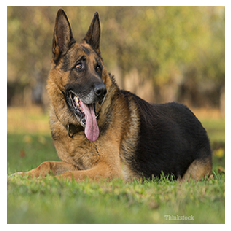

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
German shepherd, German shepherd dog, German police dog, alsatian: 74.04%
malinois: 15.15%
bulletproof vest: 0.25%
Leonberg: 0.18%
muzzle: 0.18%


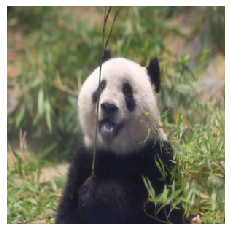

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 95.74%
lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 0.49%
brown bear, bruin, Ursus arctos: 0.06%
badger: 0.04%
ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus: 0.04%


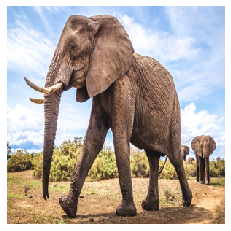

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
African elephant, Loxodonta africana: 75.62%
tusker: 19.93%
Indian elephant, Elephas maximus: 0.62%
zebra: 0.03%
trimaran: 0.01%


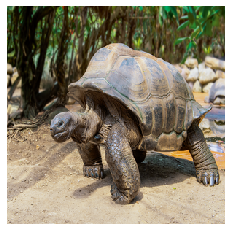

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
box turtle, box tortoise: 59.03%
terrapin: 27.07%
mud turtle: 5.54%
leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea: 0.07%
Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis: 0.05%


In [10]:
# set chop size and channel number
width = 299
height = 299
channels = 3

for img_i in range(1, 5):
    # load pictures and show original images
    image_path = 'test_image_' + str(img_i) + '.png'
    test_image = mpimg.imread(image_path)[:, :, :channels]
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()

    # rescale the image for the pre-trained model
    test_image = 2 * test_image - 1

    # run the classifier
    X_test = test_image.reshape(-1, height, width, channels)
    with tf.Session() as sess:
        saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
        predictions_val = predictions.eval(feed_dict={X: X_test})

    # get top-5 class name
    top_5 = np.argpartition(predictions_val[0], -5)[-5:]
    top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
    for i in top_5:
        print('{0}: {1:.2f}%'.format(
            class_names[i], 100 * predictions_val[0][i]))

## Transfer learning for large image classification

In [0]:
# create the flowers dataset
FLOWERS_URL = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
FLOWERS_PATH = os.path.join('datasets', 'flowers')

def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(FLOWERS_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, 'flower_photos.tgz')
    urllib.request.urlretrieve(url, 
                               tgz_path, 
                               reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

fetch_flowers()

In [0]:
# get class names
flowers_root_path = os.path.join(FLOWERS_PATH, 'flower_photos')
flower_classes = sorted(
    [dirname for dirname in os.listdir(flowers_root_path)
                  if os.path.isdir(
                      os.path.join(flowers_root_path, dirname))])

image_paths = defaultdict(list)
for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith('.jpg'):
            image_paths[flower_class].append(
                os.path.join(image_dir, filepath))

# sort the image paths by dict order
for paths in image_paths.values():
    paths.sort()

Class: daisy , 633 in total


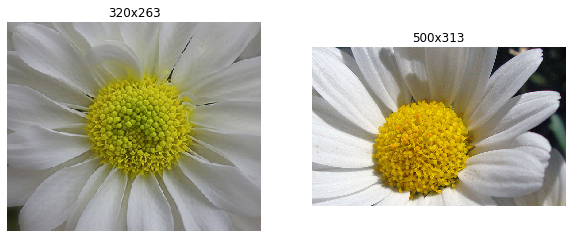

Class: dandelion , 898 in total


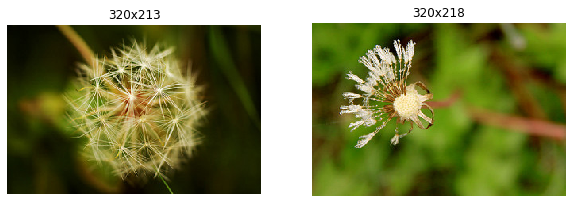

Class: roses , 641 in total


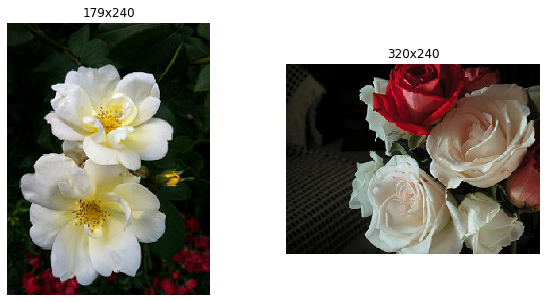

Class: sunflowers , 699 in total


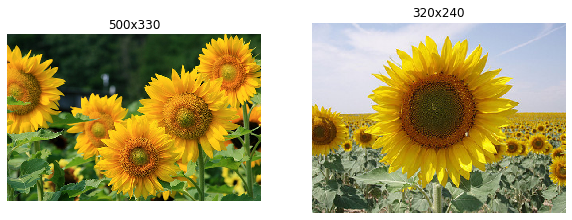

Class: tulips , 799 in total


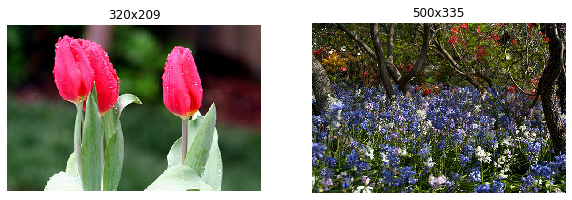

In [9]:
# take the look at each class
n_examples_per_class = 2

for flower_class in flower_classes:
    print('Class:', flower_class, ',', \
          len(image_paths[flower_class]), 'in total')
    plt.figure(figsize=(10,5))

    for index, example_image_path in enumerate(
        image_paths[flower_class][:n_examples_per_class]):

        # read image
        example_image = mpimg.imread(example_image_path)[:, :, :3]

        # plot image
        plt.subplot(100 + n_examples_per_class * 10 + index + 1)
        plt.title('{}x{}'.format(
            example_image.shape[1], 
            example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis('off')

    plt.show()

In [0]:
# resize the image into 299 * 299 and add augmentation
def prepare_image_with_tensorflow(image, 
                                  target_width = 299, 
                                  target_height = 299, 
                                  max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box 
    # with the target size ratio that fits within the image
    image_shape = tf.cast(tf.shape(image), tf.float32)
    height = image_shape[0]
    width = image_shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height

    crop_vertically = image_ratio < target_image_ratio
    crop_width = tf.cond(crop_vertically,
                         lambda: width,
                         lambda: height * target_image_ratio)
    crop_height = tf.cond(crop_vertically,
                          lambda: width / target_image_ratio,
                          lambda: height)

    # Now let's shrink this bounding box by a random factor 
    # (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = tf.random_uniform(shape=[], 
                                      minval=1.0, 
                                      maxval=1.0 + max_zoom)
    crop_width = tf.cast(crop_width / resize_factor, tf.int32)
    crop_height = tf.cast(crop_height / resize_factor, tf.int32)
    box_size = tf.stack([crop_height, crop_width, 3])

    # Let's crop the image using a random bounding box 
    # of the size we computed
    image = tf.random_crop(image, box_size)

    # Let's also flip the image horizontally with 50% probability:
    image = tf.image.random_flip_left_right(image)

    # The resize_bilinear function requires a a batch of images
    # so we need to expand the number of dimensions first:
    image_batch = tf.expand_dims(image, 0)

    # Finally, let's resize the image to the target dimensions. 
    # Note that this function returns a float32 tensor.
    image_batch = tf.image.resize_bilinear(image_batch, 
                                           [target_height, target_width])
    
    # back to a single image, and scale the colors from 0.0 to 1.0
    image = image_batch[0] / 255  
    return image

In [0]:
# use the original dataset
def prepare_image(image, 
                  target_width = 299, 
                  target_height = 299, 
                  max_zoom = 0.2):
    """Zooms and crops the image randomly for data augmentation."""

    # First, let's find the largest bounding box with the 
    # target size ratio that fits within the image
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width / height
    target_image_ratio = target_width / target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically \
                        else int(height * target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically \
                                                    else height
        
    # Now let's shrink this bounding box by a random factor 
    # (dividing the dimensions by a random number
    # between 1.0 and 1.0 + `max_zoom`.
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    # Next select a random location on the image for this bounding box.
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    # Let's crop the image using the random bounding box we built.
    image = image[y0:y1, x0:x1]

    # Let's also flip the image horizontally with 50% probability:
    if np.random.rand() < 0.5:
        image = np.fliplr(image)

    # Now, let's resize the image to the target dimensions.
    # The resize function of scikit-image will automatically transform 
    # the image to floats ranging from 0.0 to 1.0
    image = resize(image, (target_width, target_height))
    
    # Finally ensure that the colors are represented as 32-bit floats:
    return image.astype(np.float32)

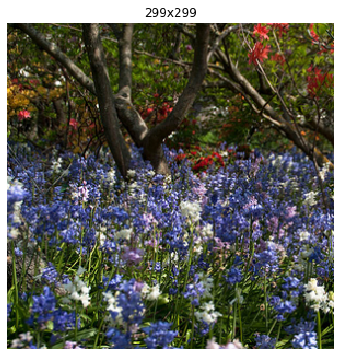

In [12]:
reset_graph()

input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prepared_image_op = prepare_image_with_tensorflow(input_image)

with tf.Session():
    prepared_image = prepared_image_op.eval(
        feed_dict={input_image: example_image})

# plot an example of the preprocessed image    
plt.figure(figsize=(6, 6))
plt.imshow(prepared_image)
plt.title('{}x{}'.format(
    prepared_image.shape[1], prepared_image.shape[0])
)
plt.axis('off')
plt.show()

In [13]:
# load the former layers
reset_graph()

X = tf.placeholder(tf.float32, 
                   shape=[None, height, width, channels], name='X')

training = tf.placeholder_with_default(False, shape=[])

with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, 
        num_classes=1001, 
        is_training=training)

inception_saver = tf.train.Saver()
prelogits = tf.squeeze(end_points['PreLogits'], axis=[1, 2])

# add a fc layer on top
n_outputs = len(flower_classes)

with tf.name_scope('new_output_layer'):
    flower_logits = tf.layers.dense(prelogits, 
                                    n_outputs, 
                                    name='flower_logits')
    Y_proba = tf.nn.softmax(flower_logits, name='Y_proba')

Instructions for updating:
Use keras.layers.Dense instead.


In [0]:
# train and eval
y = tf.placeholder(tf.int32, shape=[None])

with tf.name_scope('train'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=flower_logits, 
        labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()

    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                    scope='flower_logits')
    training_op = optimizer.minimize(loss, 
                                     var_list=flower_vars)

with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope('init_and_save'):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [15]:
# re-encode class names
flower_class_ids = {
    flower_class: index for index, flower_class in enumerate(
        flower_classes)
}
print(flower_class_ids)

flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append(
            (path, flower_class_ids[flower_class])
        )

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [16]:
# split the dataset
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

# see the splitting result
print(flower_paths_and_classes_train[:3])

[('datasets/flowers/flower_photos/daisy/19834392829_7d697871f6.jpg', 0), ('datasets/flowers/flower_photos/sunflowers/5957007921_62333981d2_n.jpg', 3), ('datasets/flowers/flower_photos/tulips/7166635566_ee240b5408_n.jpg', 4)]


In [0]:
# batch genarator
def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [
        mpimg.imread(path)[:, :, :channels] \
        for path, labels in batch_paths_and_classes
    ]

    prepared_images = [prepare_image(image) for image in images]

    # Inception expects colors ranging from -1 to 1
    X_batch = 2 * np.stack(prepared_images) - 1 
    y_batch = np.array(
        [labels for path, labels in batch_paths_and_classes], 
        dtype=np.int32)
    return X_batch, y_batch

X_batch, y_batch = prepare_batch(
    flower_paths_and_classes_train, 
    batch_size=4)
X_test, y_test = prepare_batch(
    flower_paths_and_classes_test, 
    batch_size=len(flower_paths_and_classes_test))

In [22]:
# train the model
n_epochs = 5
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)

    for epoch in range(n_epochs):
        print('Epoch', epoch, end='')
        for iteration in range(n_iterations_per_epoch):
            print('.', end='')
            X_batch, y_batch = prepare_batch(
                flower_paths_and_classes_train, batch_size)
            sess.run(training_op, 
                     feed_dict={X: X_batch, y: y_batch, training: True})

        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print('  Last batch accuracy:', acc_batch)

        save_path = saver.save(sess, './my_flowers_model')

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0.........................................................................  Last batch accuracy: 0.55
Epoch 1.........................................................................  Last batch accuracy: 0.525
Epoch 2.........................................................................  Last batch accuracy: 0.725
Epoch 3.........................................................................  Last batch accuracy: 0.5
Epoch 4.........................................................................  Last batch accuracy: 0.625


In [23]:
# test the model
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, './my_flowers_model')

    print('Computing final accuracy on the test set ...')
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(
            X_test_batches, y_test_batches)])
    print('Test accuracy:', acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set ...
Test accuracy: 0.64998144
